In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [2]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('data/train_processed.csv')
train_selected = pd.read_csv('data/train_selected.csv')

In [3]:
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [4]:
X_train = train.drop(columns=["Target",'idhogar'])
X_selected = train_selected.drop(columns=["Target",'idhogar'])
y_train = train['Target']

In [5]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

In [6]:
best_params = {'boosting_type': 'dart',
 'colsample_bytree': 0.6096416248120604,
 'learning_rate': 0.19779582059725404,
 'limit_max_depth': True,
 'max_depth': 24,
 'min_child_samples': 35,
 'num_leaves': 42,
 'reg_alpha': 0.41161294322049163,
 'reg_lambda': 0.6745579773545685,
 'subsample_for_bin': 50000,
 'drop_rate': 0.48718668776524016,
 'subsample': 0.5220648456225067,
 'subsample_freq': 9,
 'n_estimators': 120}

In [7]:
model = lgb.LGBMClassifier(**best_params, class_weight = 'balanced',
                               n_jobs=-1, metric = 'None')

In [8]:
model.fit(X_selected, y_train, )

LGBMClassifier(boosting_type='dart', class_weight='balanced',
        colsample_bytree=0.6096416248120604, drop_rate=0.48718668776524016,
        importance_type='split', learning_rate=0.19779582059725404,
        limit_max_depth=True, max_depth=24, metric='None',
        min_child_samples=35, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=120, n_jobs=-1, num_leaves=42, objective=None,
        random_state=None, reg_alpha=0.41161294322049163,
        reg_lambda=0.6745579773545685, silent=True,
        subsample=0.5220648456225067, subsample_for_bin=50000,
        subsample_freq=9)

-----------------------------

## Confusion matrix

In [9]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 208    4    6    4]
 [  13  383   26   20]
 [   5   12  327   11]
 [  55  124  165 1610]]


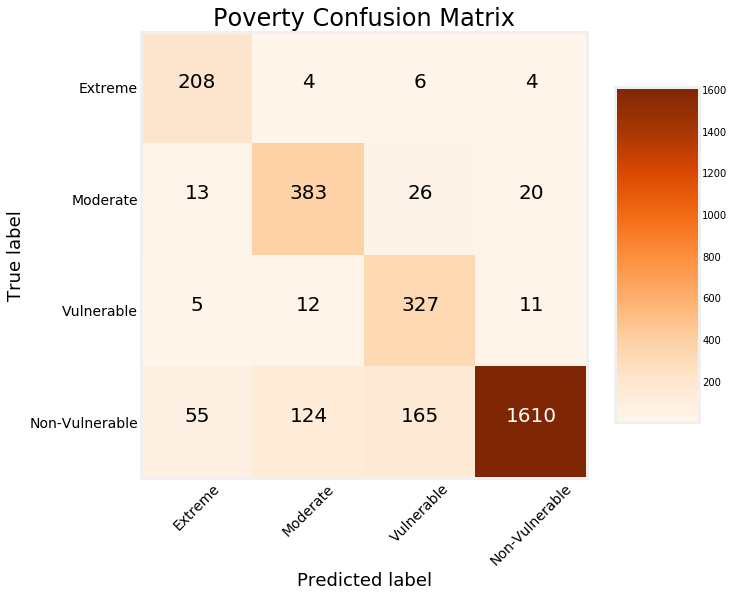

In [10]:
pred = model.predict(X_selected)
cm = confusion_matrix(y_train, pred)

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

# Feature importance

## by scikit-learn

In [11]:
df = pd.DataFrame(data={"features": X_selected.columns.values, "importance": model.feature_importances_})
df.sort_values(
    by="importance", ascending=False).head(10)

,features,importance
53,age-sum,604
61,escolari/age-sum,590
59,escolari/age-min,490
51,age-min,487
52,age-max,483
10,meaneduc,471
49,escolari-std,466
54,age-std,460
60,escolari/age-max,450
64,inst/age-max,431


## by eli5

In [12]:
p_train, p_test, l_train, l_test = train_test_split(X_selected, y_train, random_state=42)

In [13]:
model.fit(p_train, l_train)
perm = PermutationImportance(model).fit(p_test, l_test)

In [14]:
eli5.show_weights(perm, feature_names=X_selected.columns.values)

Weight,Feature
0.0132 ± 0.0107,phones-per-capita
0.0062 ± 0.0055,overcrowding
0.0059 ± 0.0044,walls+roof+floor
0.0059 ± 0.0079,estadocivil7-std
0.0056 ± 0.0062,age-sum
0.0051 ± 0.0046,paredblolad
0.0048 ± 0.0069,edjefe
0.0043 ± 0.0073,edjefa
0.0040 ± 0.0042,bonus
0.0032 ± 0.0036,lugar1


## Investigation of the confusion matrix

Confusion matrix, without normalization
[[ 22  20   9   7]
 [ 21  43  30  22]
 [ 12  19  30  29]
 [ 17  51  68 344]]


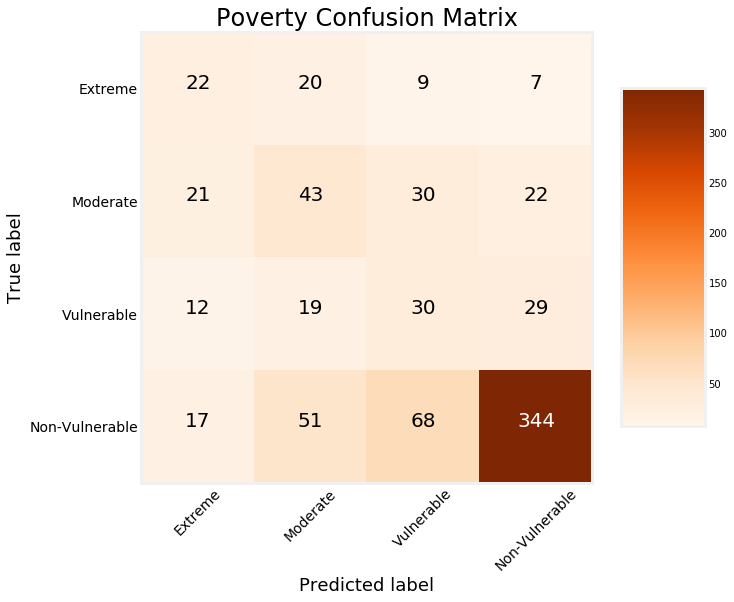

In [15]:
p_train, p_test, l_train, l_test = train_test_split(X_selected, y_train, random_state=42)
model.fit(p_train, l_train)
pred = model.predict(p_test)
cm = confusion_matrix(l_test, pred)

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

In [18]:
import shap
from IPython.display import display, HTML

shap.initjs()

def get_indexes(test_results, true_label, pred_label):
    return test_results[(test_results['Target']==true_label) & (test_results['Predicted']==pred_label)].index

def get_cofused_entries(df, test_results, true_label, pred_label):
    return df.loc[get_indexes(test_results, true_label, pred_label)]

def plot_influence_on_pred(df, shap_values, expected_value, index):
    display(HTML("<h1>What influenced prediction for {}th sample</h1>".format(index+1)))
    display(HTML("<h2>Prediction of class 4 (Non-vulnerable) probability"))
    display(shap.force_plot(expected_value[3], shap_values[3][index], df.iloc[index,:]))
    display(HTML("<h2>Prediction of class 3 (Vulnerable) probability"))
    display(shap.force_plot(expected_value[2], shap_values[2][index], df.iloc[index,:]))
    display(HTML("<h2>Prediction of class 2 (Moderate vulnerability) probability"))
    display(shap.force_plot(expected_value[1], shap_values[1][index], df.iloc[index,:]))
    display(HTML("<h2>Prediction of class 1 (Extreme vulnerability) probability"))
    display(shap.force_plot(expected_value[0], shap_values[0][index], df.iloc[index,:]))
    
def sample_and_explain(df, number_of_samples, random_state, shap_values, expected_value):
    for sample_id in df.sample(number_of_samples, random_state=random_state).index.values:
        index = df.index.get_loc(sample_id)
        plot_influence_on_pred(df, shap_values, expected_value, index)

In [19]:
test_results = pd.DataFrame(data=l_test)
test_results['Predicted'] = pred

nonvul_as_vul = get_cofused_entries(p_test, test_results, 4, 3)
vul_as_nonvul = get_cofused_entries(p_test, test_results, 3, 4)

In [20]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(nonvul_as_vul)
expected_value = explainer.expected_value
sample_and_explain(nonvul_as_vul, 3, 42, shap_values, expected_value)

In [21]:
shap_values = explainer.shap_values(vul_as_nonvul)
expected_value = explainer.expected_value
sample_and_explain(vul_as_nonvul, 3, 42, shap_values, expected_value)